In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
%cd /content/drive/MyDrive/'Research Final'/Cifar

/content/drive/MyDrive/Research Final/Cifar


In [30]:
#@title (Run) Part 1: Define required functions for Data processing

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch import Tensor
import os
import argparse
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

def balance_val_split(dataset, train_size=12500):

    try:
        targets = np.array(dataset.targets)
    except:
        targets = []  # create an empty list to store the targets
        for data in dataset.datasets:
            targets += data.targets  # concatenate the targets from each dataset into the list
        targets = np.array(targets)
    #targets = np.array(dataset.datasets.targets)
    train_indices, val_indices = train_test_split(
        np.arange(targets.shape[0]),
        train_size=train_size,
        stratify=targets
    )
    train_dataset = Subset(dataset, indices=train_indices)
    # Get the data from the subset dataset
    subset_data = [train_dataset[idx][0] for idx in range(len(train_dataset))]
    subset_labels = [train_dataset[idx][1] for idx in range(len(train_dataset))]
    # Create a dataset from the list of data and targets
    train_dataset = MyDataset(subset_data, subset_labels)
    
    
    val_dataset = Subset(dataset, indices=val_indices)
    # Get the data from the subset dataset
    subset_data = [val_dataset[idx][0] for idx in range(len(val_dataset))]
    subset_labels = [val_dataset[idx][1] for idx in range(len(val_dataset))]
    # Create a dataset from the list of data and targets
    val_dataset = MyDataset(subset_data, subset_labels)

    return train_dataset, val_dataset


def count_label_frequency(target_train_dataset):
	from collections import Counter
	target_labels = []  # create an empty list to store the labels

	for i in range(len(target_train_dataset)):
			_, label = target_train_dataset[i]  # extract the label for the i-th example in the subset
			target_labels.append(label)  # append the label to the 'subset_labels' list


	return Counter(target_labels)
 


def custom_transform(image: Tensor) -> Tensor:
    import random
    # randomly flip horizontally or vertically with 25% chance
    if random.random() < 0.25:
        image = RandomHorizontalFlip(p=1)(image)
    elif random.random() < 0.5:
        image = RandomVerticalFlip(p=1)(image)
    
    # randomly shift the image by 2 pixels to the left or right with 25% chance
    if random.random() < 0.25:
        image = RandomCrop((image.shape[-2], image.shape[-1] - 2), pad_if_needed=False)(image)
    elif random.random() < 0.5:
        image = RandomCrop((image.shape[-2], image.shape[-1] + 2), pad_if_needed=False)(image)
        
    # randomly shift the image by 2 pixels to the top or bottom with 25% chance
    if random.random() < 0.25:
        image = RandomCrop((image.shape[-2] - 2, image.shape[-1]), pad_if_needed=False)(image)
    elif random.random() < 0.5:
        image = RandomCrop((image.shape[-2] + 2, image.shape[-1]), pad_if_needed=False)(image)

    return image

In [31]:
#@title (Run) Part 2: Define required functions for Data Training

# Training
def train(trainloader, epoch, batch_size=128, logfile = "train.summary"):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        #inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        if inputs.shape[0] != batch_size:
          print(inputs.shape)
          continue
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(net.parameters(), 10)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 30 == 0:
                print(batch_idx, len(trainloader), 'Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print(len(trainloader), 'Epoch: %d | Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (epoch, train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f = open(logfile, "a")
    f.write('Epoch: %d | Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)\n'
                     % (epoch, train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f.close()

def test(testloader, epoch, batch_size=128, logfile = "train.summary", save_modelpath = './DLA'):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0



    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            #inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 30 == 0:
                print(batch_idx, len(testloader), 'Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print(len(testloader), 'Epoch: %d | Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f = open(logfile, "a")
    f.write('Epoch: %d | Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)\n'
                         % (epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f.close()
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(save_modelpath):
            os.mkdir(save_modelpath)
        torch.save(state, save_modelpath+'/ckpt.pth')
        best_acc = acc

def draw_training_summary(filepath = 'target_train_DCA-BiLSTM.summary'):
    import matplotlib.pyplot as plt
    import numpy as np

    with open(filepath, 'r') as f:
        results_summary = f.read()

    train_epoch = []
    train_loss = []
    train_acc = []
    test_epoch = []
    test_loss=[]
    test_acc=[]
    for line in results_summary.split("\n"):
        try:
            r_epoch = line.split('|')[0].strip().split(' ')[1]
            r_loss = line.split('|')[1].strip().split(' ')[2].replace('%','')
            r_acc = line.split('|')[2].strip().split(' ')[2].replace('%','')
            if 'Train' in line:
                train_epoch.append(int(r_epoch))
                train_loss.append(float(r_loss))
                train_acc.append(float(r_acc))
            if 'Test' in line:
                test_epoch.append(int(r_epoch))
                test_loss.append(float(r_loss))
                test_acc.append(float(r_acc))
        except:
            print(line)

    # Create a new figure and plot the data
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(train_acc, label='Train')
    plt.plot(test_acc, label='Test')
    plt.axhline(y=np.max(test_acc), color='r', linestyle='--')
    # Add text for the horizontal line
    plt.text(test_epoch[-10], np.max(test_acc)*1.05, np.max(test_acc), color='r', fontsize=10)
    # Customize the plot
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_loss, label='Train')
    plt.plot(test_loss, label='Test')

    # Customize the plot
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()



    # Display the plot
    plt.show()

In [32]:
#@title (Run) Part 3: Prepare Cifar10 dataset for target and shadow model
import pickle
from torch.utils.data import DataLoader
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def create_cifar_dataset_torch(load_data = False, batch_size=128, target_train_size = 15000, target_test_size= 15000, shadow_train_size = 15000, shadow_test_size= 15000):

  # Data
  print('==> Preparing data..')
  if not load_data:

      transform = transforms.Compose([
            transforms.ToTensor()
        ])

      cifar_trainset = torchvision.datasets.CIFAR10(
          root='./data', train=True, download=True, transform=transform)


      cifar_testset = torchvision.datasets.CIFAR10(
          root='./data', train=False, download=True, transform=transform)

      cifar_dataset = torch.utils.data.ConcatDataset([cifar_trainset, cifar_testset])


      #target_train_size = int(0.25 * len(cifar_dataset)) # 15000
      remain_size = len(cifar_dataset) - target_train_size
      target_train_dataset, remain_dataset = torch.utils.data.random_split(cifar_dataset, [target_train_size, remain_size])

      #target_test_size = int(0.25 * len(cifar_dataset)) # 15000
      remain_size = len(remain_dataset) - target_test_size
      target_test_dataset, remain_dataset = torch.utils.data.random_split(remain_dataset, [target_test_size, remain_size])

      #target_test_dataset, remain_dataset = balance_val_split(remain_dataset, train_size=target_test_size)


      #shadow_train_size = int(0.25 * len(cifar_dataset)) # 15000
      remain_size = len(remain_dataset) - shadow_train_size
      shadow_train_dataset, shadow_test_dataset = torch.utils.data.random_split(remain_dataset, [shadow_train_size, remain_size])
      #shadow_train_dataset, shadow_test_dataset = balance_val_split(remain_dataset, train_size=shadow_train_size)

      print("Setting target_train_dataset size to ",len(target_train_dataset), count_label_frequency(target_train_dataset))
      print("Setting target_test_dataset size to ",len(target_test_dataset), count_label_frequency(target_test_dataset))
      print("Setting shadow_train_dataset size to ",len(shadow_train_dataset), count_label_frequency(shadow_train_dataset))
      print("Setting shadow_test_dataset size to ",len(shadow_test_dataset), count_label_frequency(shadow_test_dataset))
      #print("Setting testset size to ",len(testset))



      '''
      transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])
      '''



      transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          custom_transform,
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])

      transform_test = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])

      # apply the data augmentation transformations to the subset
      target_train_dataset.dataset.transform = transform_train
      # Load the transformed subset using a DataLoader
      target_trainloader = DataLoader(target_train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)


      target_test_dataset.dataset.transform = transform_test
      # Load the transformed subset using a DataLoader
      target_testloader = DataLoader(target_test_dataset, batch_size=batch_size, shuffle=True, drop_last = True)


      # apply the data augmentation transformations to the subset
      shadow_train_dataset.dataset.transform = transform_train
      # Load the transformed subset using a DataLoader
      shadow_trainloader = DataLoader(shadow_train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)


      shadow_test_dataset.dataset.transform = transform_test
      # Load the transformed subset using a DataLoader
      shadow_testloader = DataLoader(shadow_test_dataset, batch_size=batch_size, shuffle=True, drop_last = True)

      pickle.dump(target_trainloader, open('target_trainloader_renet.p', 'wb'))
      pickle.dump(target_testloader, open('target_testloader_renet.p', 'wb'))
      pickle.dump(shadow_trainloader, open('shadow_trainloader_renet.p', 'wb'))
      pickle.dump(shadow_testloader, open('shadow_test_dataset_renet.p', 'wb'))
    
  data_file = open('target_trainloader_renet.p', 'rb')
  target_trainloader = pickle.load(data_file)
  data_file.close()
  data_file = open('target_testloader_renet.p', 'rb')
  target_testloader = pickle.load(data_file)
  data_file.close()
  data_file = open('shadow_trainloader_renet.p', 'rb')
  shadow_trainloader = pickle.load(data_file)
  data_file.close()
  data_file = open('shadow_test_dataset_renet.p', 'rb')
  shadow_testloader = pickle.load(data_file)
  data_file.close()


  return target_trainloader, target_testloader, shadow_trainloader, shadow_testloader


In [33]:
#@title (Run) Part 4.1: Define required functions for ReNet

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Subset, DataLoader
import os
import numpy as np
import argparse

from sklearn.model_selection import train_test_split

#on hopper: pip install --upgrade torch==2.0.0+cu118 torchvision==0.15.0+cu118 -f https://download.pytorch.org/whl/torch_stable.html



# renet with one layer
class ReNet(nn.Module):
	def __init__(self, receptive_filter_size, hidden_size, batch_size, image_patches_height, image_patches_width):

		super(ReNet, self).__init__()

		self.batch_size = batch_size
		self.receptive_filter_size = receptive_filter_size
		self.input_size1 = receptive_filter_size * receptive_filter_size * 3
		self.input_size2 = hidden_size * 2
		self.hidden_size = hidden_size

		# vertical rnns
		self.rnn1 = nn.LSTM(self.input_size1, self.hidden_size, dropout = 0.2)
		self.rnn2 = nn.LSTM(self.input_size1, self.hidden_size, dropout = 0.2)

		# horizontal rnns
		self.rnn3 = nn.LSTM(self.input_size2, self.hidden_size, dropout = 0.2)
		self.rnn4 = nn.LSTM(self.input_size2, self.hidden_size, dropout = 0.2)

		self.initHidden()

		feature_map_dim = int(image_patches_height*image_patches_height*hidden_size*2)
		#self.conv1 = nn.Conv2d(hidden_size*2, 2, 3,padding=1)#[1,640,8,8]->[1,1,8,8]
		#self.UpsamplingBilinear2d=nn.UpsamplingBilinear2d(size=(32,32), scale_factor=None)
		self.dense = nn.Linear(feature_map_dim, 1024) #4096
		self.fc = nn.Linear(1024, 10)

		self.log_softmax = nn.LogSoftmax()

	def initHidden(self):
		self.hidden = (Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()), Variable(torch.zeros(1, self.batch_size, self.hidden_size)).cuda())


	def get_image_patches(self, X, receptive_filter_size):
		"""
		creates image patches based on the dimension of a receptive filter
		"""
		image_patches = []

		_, X_channel, X_height, X_width= X.size()


		for i in range(0, X_height, receptive_filter_size):
			for j in range(0, X_width, receptive_filter_size):
				X_patch = X[:, :, i: i + receptive_filter_size, j : j + receptive_filter_size]
				image_patches.append(X_patch)

		image_patches_height = (X_height // receptive_filter_size)
		image_patches_width = (X_width // receptive_filter_size)


		image_patches = torch.stack(image_patches)
		image_patches = image_patches.permute(1, 0, 2, 3, 4)
		#print("image_patches: ",image_patches.shape)

		image_patches = image_patches.contiguous().view(-1, image_patches_height, image_patches_height, receptive_filter_size * receptive_filter_size * X_channel)

		return image_patches



	def get_vertical_rnn_inputs(self, image_patches, forward):
		"""
		creates vertical rnn inputs in dimensions 
		(num_patches, batch_size, rnn_input_feature_dim)
		num_patches: image_patches_height * image_patches_width
		"""
		vertical_rnn_inputs = []
		_, image_patches_height, image_patches_width, feature_dim = image_patches.size()

		if forward:
			for i in range(image_patches_height):
				for j in range(image_patches_width):
					vertical_rnn_inputs.append(image_patches[:, j, i, :])

		else:
			for i in range(image_patches_height-1, -1, -1):
				for j in range(image_patches_width-1, -1, -1):
					vertical_rnn_inputs.append(image_patches[:, j, i, :])

		vertical_rnn_inputs = torch.stack(vertical_rnn_inputs)


		return vertical_rnn_inputs



	def get_horizontal_rnn_inputs(self, vertical_feature_map, image_patches_height, image_patches_width, forward):
		"""
		creates vertical rnn inputs in dimensions 
		(num_patches, batch_size, rnn_input_feature_dim)
		num_patches: image_patches_height * image_patches_width
		"""
		horizontal_rnn_inputs = []

		if forward:
			for i in range(image_patches_height):
				for j in range(image_patches_width):
					horizontal_rnn_inputs.append(vertical_feature_map[:, i, j, :])
		else:
			for i in range(image_patches_height-1, -1, -1):
				for j in range(image_patches_width -1, -1, -1):
					horizontal_rnn_inputs.append(vertical_feature_map[:, i, j, :])
		
		horizontal_rnn_inputs = torch.stack(horizontal_rnn_inputs)

		return horizontal_rnn_inputs


	def forward(self, X):

		"""ReNet """

		# divide input input image to image patches
		image_patches = self.get_image_patches(X, self.receptive_filter_size)
		_, image_patches_height, image_patches_width, feature_dim = image_patches.size()

		# process vertical rnn inputs
		vertical_rnn_inputs_fw = self.get_vertical_rnn_inputs(image_patches, forward=True)
		vertical_rnn_inputs_rev = self.get_vertical_rnn_inputs(image_patches, forward=False)
    
		#print("vertical_rnn_inputs_fw: ",vertical_rnn_inputs_fw.shape)
		#print("vertical_rnn_inputs_rev: ",vertical_rnn_inputs_rev.shape)
		# extract vertical hidden states
		vertical_forward_hidden, vertical_forward_cell = self.rnn1(vertical_rnn_inputs_fw, self.hidden)
		vertical_reverse_hidden, vertical_reverse_cell = self.rnn2(vertical_rnn_inputs_rev, self.hidden)

		# create vertical feature map
		vertical_feature_map = torch.cat((vertical_forward_hidden, vertical_reverse_hidden), 2)
		vertical_feature_map =  vertical_feature_map.permute(1, 0, 2)

		# reshape vertical feature map to (batch size, image_patches_height, image_patches_width, hidden_size * 2)
		vertical_feature_map = vertical_feature_map.contiguous().view(-1, image_patches_width, image_patches_height, self.hidden_size * 2)
		vertical_feature_map.permute(0, 2, 1, 3)

		# process horizontal rnn inputs
		horizontal_rnn_inputs_fw = self.get_horizontal_rnn_inputs(vertical_feature_map, image_patches_height, image_patches_width, forward=True)
		horizontal_rnn_inputs_rev = self.get_horizontal_rnn_inputs(vertical_feature_map, image_patches_height, image_patches_width, forward=False)

		#print("horizontal_rnn_inputs_fw1: ",horizontal_rnn_inputs_fw.shape)
		#print("horizontal_rnn_inputs_rev1: ",horizontal_rnn_inputs_rev.shape)
		# extract horizontal hidden states
		horizontal_forward_hidden, horizontal_forward_cell = self.rnn3(horizontal_rnn_inputs_fw, self.hidden)
		horizontal_reverse_hidden, horizontal_reverse_cell = self.rnn4(horizontal_rnn_inputs_rev, self.hidden)

		# create horiztonal feature map[64,1,320]
		#print("horizontal_forward_hidden2: ",horizontal_forward_hidden.shape)
		#print("horizontal_reverse_hidden2: ",horizontal_reverse_hidden.shape)
		horizontal_feature_map = torch.cat((horizontal_forward_hidden, horizontal_reverse_hidden), 2)
		horizontal_feature_map =  horizontal_feature_map.permute(1, 0, 2)

		# flatten[1,64,640]
		output = horizontal_feature_map.contiguous().view(-1, image_patches_height , image_patches_width , self.hidden_size * 2)
		output = output.view(output.size(0), -1)
		#output=output.permute(0,3,1,2)#[1,640,8,8]
		#conv1=self.conv1(output)
		#Upsampling=self.UpsamplingBilinear2d(conv1)
		# dense layer
		output = F.relu(self.dense(output))
		 
		# fully connected layer
		logits = self.fc(output)

		# log softmax
		#logits = self.log_softmax(Upsampling)

		return logits


    


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    s = '%s' % (asMinutes(s))
    return s


'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import os
import sys
import time
import math
from torch import Tensor
import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)



In [34]:
#@title (Run) Part 5.1.1: Select an architecture for Target model training
from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: ReNet
#@markdown * Option 2: DLA
#@markdown * Option 3: DLA-LSTM
#@markdown * Option 4: DLA-BiLSTM


method_name = 'ReNet'  #@param {type:"string"}
save_model_folder = './Target-ReNet_models/'   #@param {type:"string"}
batch_size = 128  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}

if method_name == 'ReNet':
  # Model
  print('==> Building model for ' + method_name)

  receptive_filter_size = 4
  hidden_size = 320
  image_size_w = 32
  image_size_h = 32
  

  net = ReNet(receptive_filter_size, hidden_size, batch_size, image_size_w/receptive_filter_size, image_size_h/receptive_filter_size)
  net.cuda()

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
  if load_pretrain_weight:
    try:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        checkpoint = torch.load(save_model_folder+'/ckpt.pth')
        net.load_state_dict(checkpoint['net'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']
    except:
        print('!!! Error: no checkpoint directory found!')
  else:
    print('==> Training model from scratch..')

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.01,
                        momentum=0.9, weight_decay=5e-4)
  #optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

  pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  print("Total trained parameters: ",pytorch_total_params)


print(net)

==> Building model for ReNet


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


==> Training model from scratch..
Total trained parameters:  45364234
ReNet(
  (rnn1): LSTM(48, 320, dropout=0.2)
  (rnn2): LSTM(48, 320, dropout=0.2)
  (rnn3): LSTM(640, 320, dropout=0.2)
  (rnn4): LSTM(640, 320, dropout=0.2)
  (dense): Linear(in_features=40960, out_features=1024, bias=True)
  (fc): Linear(in_features=1024, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=None)
)


In [35]:
#@title (Run) Part 5.1.2: Setup Target and Shadow datasets for ReNet Training

target_train_size = 15000 #@param {type:"integer"}
target_test_size= 15000 #@param {type:"integer"}
shadow_train_size = 15000  #@param {type:"integer"} 
shadow_test_size= 15000 #@param {type:"integer"}

# create dataset for renet 
print('==> Preparing dataset..')
target_trainloader, target_testloader, shadow_trainloader, shadow_testloader = create_cifar_dataset_torch(load_data = False, batch_size=batch_size, target_train_size = target_train_size, target_test_size= target_test_size, shadow_train_size = shadow_train_size, shadow_test_size= shadow_test_size)


==> Preparing dataset..
==> Preparing data..


100%|██████████| 170498071/170498071 [00:13<00:00, 12857580.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Setting target_train_dataset size to  15000 Counter({2: 1595, 9: 1526, 8: 1518, 0: 1510, 6: 1510, 4: 1501, 3: 1490, 1: 1456, 7: 1453, 5: 1441})
Setting target_test_dataset size to  15000 Counter({7: 1570, 3: 1552, 4: 1540, 9: 1529, 5: 1524, 2: 1505, 6: 1475, 1: 1453, 8: 1439, 0: 1413})
Setting shadow_train_dataset size to  15000 Counter({5: 1554, 1: 1540, 0: 1521, 2: 1516, 8: 1512, 6: 1502, 7: 1480, 4: 1471, 3: 1464, 9: 1440})
Setting shadow_test_dataset size to  15000 Counter({0: 1556, 1: 1551, 8: 1531, 6: 1513, 9: 1505, 7: 1497, 3: 1494, 4: 1488, 5: 1481, 2: 1384})


In [36]:
#@title (Run) Part 5.1.3: Start Target model training

max_epoch = 50  #@param {type:"integer"}
train_result_summary = 'target_train_ReNet.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(target_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(target_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    scheduler.step()


Epoch: 0
0 117 Train Loss: 2.300 | Train Acc: 10.156% (13/128)
30 117 Train Loss: 2.299 | Train Acc: 13.306% (528/3968)
60 117 Train Loss: 2.295 | Train Acc: 14.793% (1155/7808)
90 117 Train Loss: 2.289 | Train Acc: 14.947% (1741/11648)
117 Epoch: 0 | Train Loss: 2.280 | Train Acc: 15.258% (2285/14976)
0 117 Test Loss: 2.255 | Test Acc: 10.938% (14/128)
30 117 Test Loss: 2.236 | Test Acc: 14.541% (577/3968)
60 117 Test Loss: 2.236 | Test Acc: 15.010% (1172/7808)
90 117 Test Loss: 2.235 | Test Acc: 15.196% (1770/11648)
117 Epoch: 0 | Test Loss: 2.237 | Test Acc: 15.051% (2254/14976)
Saving..

Epoch: 1
0 117 Train Loss: 2.244 | Train Acc: 15.625% (20/128)
30 117 Train Loss: 2.194 | Train Acc: 19.002% (754/3968)
60 117 Train Loss: 2.174 | Train Acc: 19.160% (1496/7808)
90 117 Train Loss: 2.155 | Train Acc: 20.072% (2338/11648)
117 Epoch: 1 | Train Loss: 2.141 | Train Acc: 20.700% (3100/14976)
0 117 Test Loss: 2.104 | Test Acc: 17.969% (23/128)
30 117 Test Loss: 2.076 | Test Acc: 23.438% 

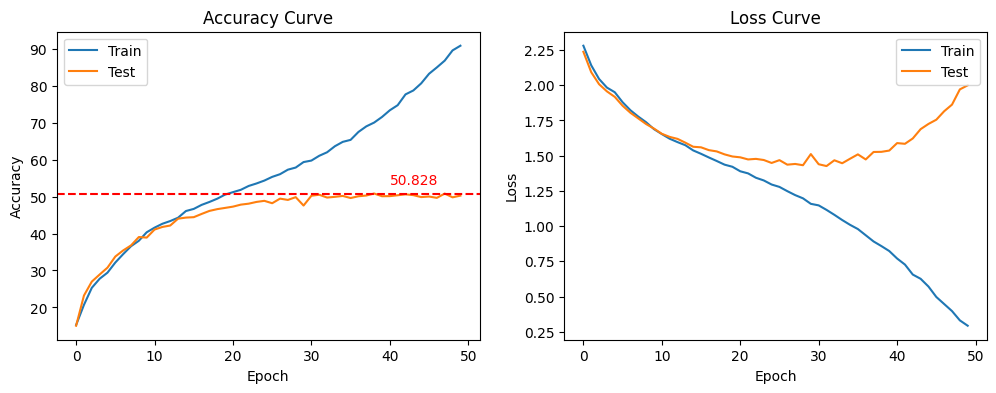

In [37]:
draw_training_summary(filepath = 'target_train_ReNet.summary')

In [38]:
#@title (Run) Part 5.1.1: Select an architecture for Target model training
from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: ReNet
#@markdown * Option 2: DLA
#@markdown * Option 3: DLA-LSTM
#@markdown * Option 4: DLA-BiLSTM


method_name = 'ReNet'  #@param {type:"string"}
save_model_folder = './Shadow-ReNet_models/'   #@param {type:"string"}
batch_size = 128  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}

if method_name == 'ReNet':
  # Model
  print('==> Building model for ' + method_name)

  receptive_filter_size = 4
  hidden_size = 320
  image_size_w = 32
  image_size_h = 32
  

  net = ReNet(receptive_filter_size, hidden_size, batch_size, image_size_w/receptive_filter_size, image_size_h/receptive_filter_size)
  net.cuda()

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
  if load_pretrain_weight:
    try:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        checkpoint = torch.load(save_model_folder+'/ckpt.pth')
        net.load_state_dict(checkpoint['net'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']
    except:
        print('!!! Error: no checkpoint directory found!')
  else:
    print('==> Training model from scratch..')

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.01,
                        momentum=0.9, weight_decay=5e-4)
  #optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

  pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  print("Total trained parameters: ",pytorch_total_params)


print(net)

==> Building model for ReNet
==> Training model from scratch..
Total trained parameters:  45364234
ReNet(
  (rnn1): LSTM(48, 320, dropout=0.2)
  (rnn2): LSTM(48, 320, dropout=0.2)
  (rnn3): LSTM(640, 320, dropout=0.2)
  (rnn4): LSTM(640, 320, dropout=0.2)
  (dense): Linear(in_features=40960, out_features=1024, bias=True)
  (fc): Linear(in_features=1024, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=None)
)


In [39]:
#@title (Run) Part 5.1.3: Start Target model training

max_epoch = 50  #@param {type:"integer"}
train_result_summary = 'shadow_train_ReNet.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(shadow_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(shadow_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    scheduler.step()


Epoch: 0
0 117 Train Loss: 2.305 | Train Acc: 9.375% (12/128)
30 117 Train Loss: 2.300 | Train Acc: 10.232% (406/3968)
60 117 Train Loss: 2.294 | Train Acc: 12.423% (970/7808)
90 117 Train Loss: 2.286 | Train Acc: 13.427% (1564/11648)
117 Epoch: 0 | Train Loss: 2.275 | Train Acc: 14.303% (2142/14976)
0 117 Test Loss: 2.211 | Test Acc: 17.188% (22/128)
30 117 Test Loss: 2.204 | Test Acc: 21.346% (847/3968)
60 117 Test Loss: 2.208 | Test Acc: 21.491% (1678/7808)
90 117 Test Loss: 2.207 | Test Acc: 21.600% (2516/11648)
117 Epoch: 0 | Test Loss: 2.208 | Test Acc: 21.554% (3228/14976)
Saving..

Epoch: 1
0 117 Train Loss: 2.196 | Train Acc: 27.344% (35/128)
30 117 Train Loss: 2.181 | Train Acc: 19.834% (787/3968)
60 117 Train Loss: 2.152 | Train Acc: 20.261% (1582/7808)
90 117 Train Loss: 2.131 | Train Acc: 20.742% (2416/11648)
117 Epoch: 1 | Train Loss: 2.118 | Train Acc: 21.247% (3182/14976)
0 117 Test Loss: 2.049 | Test Acc: 17.188% (22/128)
30 117 Test Loss: 2.086 | Test Acc: 23.715% (9

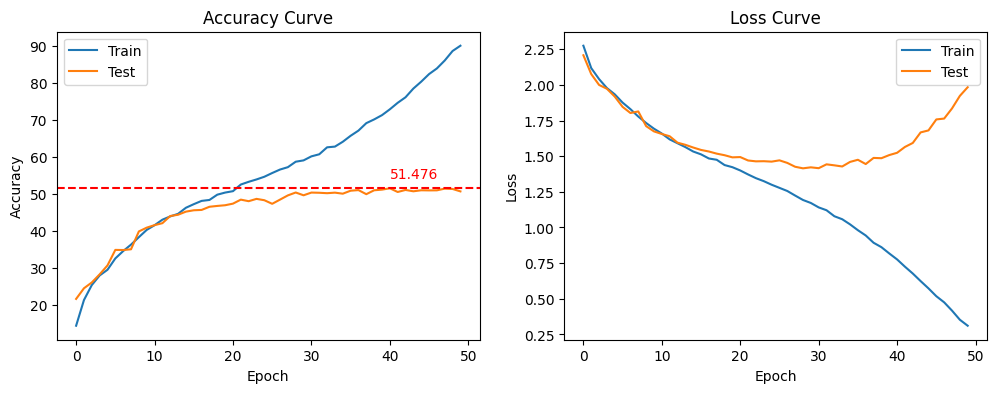

In [40]:
draw_training_summary(filepath = 'shadow_train_ReNet.summary')